# Feb 25th, 2022 (ROI plots)

**Motivation**: ROIs, top, flat, coverage, etc.  <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Fig dir

In [2]:
fig_dir = pjoin(tmp_dir, 'fig_25th')
os.makedirs(fig_dir, exist_ok=True)

## Prepare

In [3]:
mice = Mice((128, 0, 100))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

num_k, perc = 5, 10
props_base = {
    'perc': f'p{perc}-sample',
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bold = {'mode': 'bold-lite', **props_base}

In [4]:
gr_ca = Group(**props_ca).fit_group()
gr_bold = Group(**props_bold).fit_group()

sim = dist2sim(sp_dist.cdist(
    XA=gr_bold.grp_pi,
    XB=gr_ca.grp_pi,
    metric='cosine',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bold.pi = gr_bold.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

proj_bold = gr_bold.project_vec()
proj_ca = gr_ca.project_vec()

ids

[0, 1, 2, 3, 4]

## Optical

In [5]:
from register.register import reset_ants_img

In [6]:
mice = Mice(128, load_allen=True)
mice.setup_anat_data()

In [134]:
key = 'sub-SLC08_ses-2'

roi_2d = f"{key}_space-indiv2d_cortex.nii.gz"
roi_2d = pjoin(mice.cfg.masks_dir, roi_2d)
roi_2d = ants.image_read(roi_2d, pixeltype='unsigned int')
roi_2d = reset_ants_img(
    img=roi_2d.numpy().squeeze(),
    spacing=roi_2d.spacing[:2],
    origin=0, use_um=False,
)

ref = mice.ref[key].load_ants('float')
ref = reset_ants_img(
    img=ref.numpy().squeeze(),
    spacing=ref.spacing[:2],
    origin=0, use_um=False,
)
mask = mice.mask2d[key].load_ants('unsigned int')

roi_2d = ants.resample_image_to_target(
    image=roi_2d, target=mask,
    interp_type='genericLabel',
)
ref = ants.resample_image_to_target(
    image=ref, target=mask,
    interp_type='linear',
)
roi_2d *= mask
ref *= mask

mask = mask.numpy()
roi_2d = roi_2d.numpy()
ref = ref.numpy()

In [135]:
regions_here = roi_2d[roi_2d.nonzero()]
regions_here = np.unique(regions_here)
hcl = mice.parcel.decode(regions_here)
regions_here_r = regions_here[hcl[:, 0] == 2]

for r in regions_here:
    hh, cc, ll = mice.parcel.decode(r).ravel()
    if ll == 1:
        roi_2d[roi_2d == r] = mice.parcel.encode(f"{hh}-{cc}-0")

In [136]:
roi_tr, m_tr, ref_tr = filter_boundaries([roi_2d, mask, ref], mask)

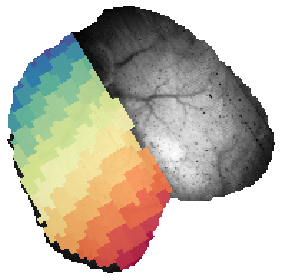

In [137]:
fig, ax = create_figure()

x2p = np.ma.masked_where(m_tr == 0, ref_tr)
plt.imshow(x2p, cmap='Greys_r')

x2p = np.ma.masked_where(~np.isin(roi_tr, regions_here_r), roi_tr)
plt.imshow(x2p, cmap='Spectral_r', interpolation='none', alpha=0.9)

remove_ticks(ax)

name = f'ROI-indiv2d'
figname = f"{name}.pdf"
fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
for dpi in [100, 300, 600]:
    figname = f"{name}_dpi{dpi}.png"
    fig.savefig(pjoin(fig_dir, figname), dpi=dpi, bbox_inches='tight', transparent=True)

plt.show()

In [8]:
key = 'sub-SLC08_ses-2'

In [9]:
roi_3d = f"{key}_space-indiv3d_cortex.nii.gz"
roi_3d = pjoin(mice.cfg.masks_dir, roi_3d)
roi_3d = ants.image_read(roi_3d, pixeltype='unsigned int')
roi_3d = roi_3d.numpy()

In [10]:
regions_included = roi_3d[roi_3d.nonzero()]
regions_included = np.unique(regions_included)
hcl = mice.parcel.decode(regions_included)
regions_included_surface = regions_included[hcl[:, 2] == 0]

len(regions_included), len(regions_included_surface)

(758, 255)

In [11]:
roi_3d[~np.isin(roi_3d, regions_included_surface)] = 0

In [12]:
m3d = mice.mask3d[key].load_ants().numpy() 
t1w = mice.T1w[key].load_ants().numpy()

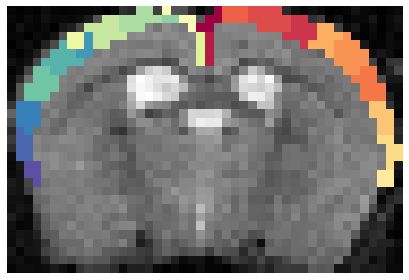

In [74]:
jj = 45

x2p = roi_3d[..., jj].T.copy()
x2p_rename = np.zeros(x2p.shape)

for i, r in enumerate(np.unique(x2p[x2p.nonzero()])):
    x2p_rename[x2p == r] = i + 1
    
_m3d = m3d[..., jj].T
_t1w = t1w[..., jj].T

_roi3d, _m3d, _t1w = filter_boundaries([x2p_rename, _m3d, _t1w], _m3d) 

fig, ax = create_figure()

x2p = np.ma.masked_where(_m3d == 0, _t1w)
ax.imshow(_t1w, cmap='Greys_r')
x2p = np.ma.masked_where(_roi3d == 0, _roi3d)
ax.imshow(x2p, cmap='Spectral_r')
remove_ticks(ax)

name = f'ROI-indiv3d'
figname = f"{name}.pdf"
fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
for dpi in [100, 300, 600]:
    figname = f"{name}_dpi{dpi}.png"
    fig.savefig(pjoin(fig_dir, figname), dpi=dpi, bbox_inches='tight', transparent=True)


plt.show()

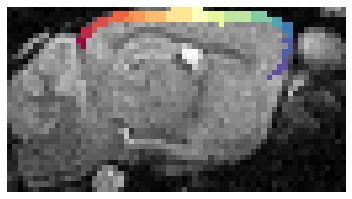

In [86]:
jj = 39
_roi3d, _m3d, _t1w = filter_boundaries([roi_3d[jj], m3d[jj], t1w[jj]], m3d[jj])

fig, ax = create_figure(figsize=(5, 3))

ax.imshow(_t1w, cmap='Greys_r')

x2p = np.ma.masked_where(~np.isin(_roi3d, regions_included_surface), _roi3d)
ax.imshow(x2p, cmap='Spectral_r')
remove_ticks(ax)

name = f'ROI-indiv3d-sag'
figname = f"{name}.pdf"
fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
for dpi in [100, 300, 600]:
    figname = f"{name}_dpi{dpi}.png"
    fig.savefig(pjoin(fig_dir, figname), dpi=dpi, bbox_inches='tight', transparent=True)
    
plt.show()

<matplotlib.image.AxesImage object at 0x7f200ecb55b0>

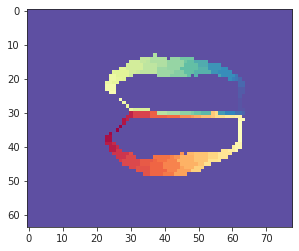

In [194]:

x2p = roi_3d[:, 7].copy()
x2p_rename = np.zeros(x2p.shape)

for i, r in enumerate(np.unique(x2p[x2p.nonzero()])):
    x2p_rename[x2p == r] = i + 1
plt.imshow(x2p_rename, cmap='Spectral_r')

In [220]:
from register.register import Register

In [221]:
reg = Register(mice)
reg.set_mode('ca2')

In [222]:
output = reg.get_accepted_regions()

Name: cortex . . . a total of: 174 regions accepted, 594 regions rejected.
accept ratio: 22.66 %, reject ratio: 77.34 %, using a presence threshold of 10.0 %

In [223]:
list(output)

['df', 'cortex', 'subcortex']

In [227]:
freq = output['cortex']['freq']

In [231]:
top, flat = gr_ca.load_top_flat()

# load parcel flatt & top
parcel_flat = 'parcel2d-flat_10um.nii.gz'
parcel_flat = pjoin(mice.cfg.parcel_dir, parcel_flat)
parcel_flat = ants.image_read(parcel_flat).numpy()

parcel_top = 'parcel2d-top_10um.nii.gz'
parcel_top = pjoin(mice.cfg.parcel_dir, parcel_top)
parcel_top = ants.image_read(parcel_top).numpy()

<matplotlib.image.AxesImage object at 0x7f200c95f460>

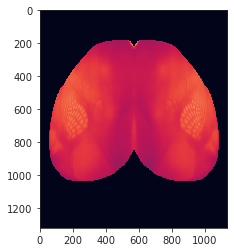

In [230]:
plt.imshow(top)

In [242]:
freq_ctx = np.zeros(top.shape, dtype=float)
for r, f in freq.items():
    m = parcel_top == r
    if not m.sum():
        continue
    freq_ctx[m] = f
    
freq_ctx *= 100

In [244]:
f_tr, t_tr = filter_boundaries([freq_ctx, top], top.astype(bool))

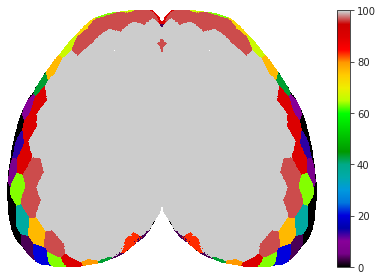

In [252]:
fig, ax = create_figure()

x2p = np.ma.masked_where(t_tr == 0, t_tr)
plt.imshow(x2p)

x2p = np.ma.masked_where(t_tr == 0, f_tr)
plt.imshow(x2p, cmap='nipy_spectral')
plt.colorbar()

remove_ticks(ax)

name = f'coverage-top'
figname = f"{name}.pdf"
fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
for dpi in [100, 300, 600]:
    figname = f"{name}_dpi{dpi}.png"
    fig.savefig(pjoin(fig_dir, figname), dpi=dpi, bbox_inches='tight', transparent=True)

plt.show()

In [253]:
freq_ctx = np.zeros(flat.shape, dtype=float)
for r, f in freq.items():
    m = parcel_flat == r
    if not m.sum():
        continue
    freq_ctx[m] = f
freq_ctx *= 100

In [255]:
f_tr, t_tr = filter_boundaries([freq_ctx, flat], flat.astype(bool))

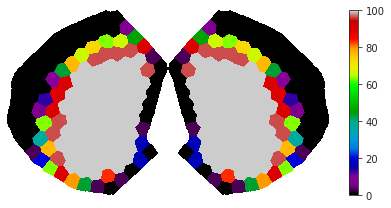

In [257]:
fig, ax = create_figure(figsize=(6, 3))

x2p = np.ma.masked_where(t_tr == 0, t_tr)
plt.imshow(x2p)

x2p = np.ma.masked_where(t_tr == 0, f_tr)
plt.imshow(x2p, cmap='nipy_spectral')
plt.colorbar()

remove_ticks(ax)

name = f'coverage-flat'
figname = f"{name}.pdf"
fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
for dpi in [100, 300, 600]:
    figname = f"{name}_dpi{dpi}.png"
    fig.savefig(pjoin(fig_dir, figname), dpi=dpi, bbox_inches='tight', transparent=True)

plt.show()

## Top & Flat

In [5]:
mice = Mice((128, 0, 100))

In [6]:
top, flat = gr_bold.load_top_flat()

In [7]:
# load parcel flatt & top
parcel_flat = 'parcel2d-flat_10um.nii.gz'
parcel_flat = pjoin(mice.cfg.parcel_dir, parcel_flat)
parcel_flat = ants.image_read(parcel_flat).numpy()

parcel_top = 'parcel2d-top_10um.nii.gz'
parcel_top = pjoin(mice.cfg.parcel_dir, parcel_top)
parcel_top = ants.image_read(parcel_top).numpy()

In [8]:
figs_dir = pjoin(tmp_dir, 'fig_topflat')
os.makedirs(figs_dir, exist_ok=True)

In [107]:
kws = {
    'transparent': True,
    'bbox_inches': 'tight',
}

In [106]:
flat_tr, parcel_flat_tr = filter_boundaries([flat, parcel_flat], flat)

fig, ax = create_figure(figsize=(23, 10))
ax.imshow(flat_tr, cmap='Greys_r')
x2p = np.ma.masked_where(~np.isin(parcel_flat_tr, range(1, 128 + 1)), parcel_flat_tr)
plt.imshow(x2p, cmap='Spectral_r')
remove_ticks(ax)
fig.savefig(pjoin(figs_dir, 'flat_tr_noticks_with_parcel.pdf'), **kws)
plt.close()

In [108]:
top_tr, parcel_top_tr = filter_boundaries([top, parcel_top], top)

fig, ax = create_figure(figsize=(13, 20))
ax.imshow(top_tr, cmap='Greys_r')
x2p = np.ma.masked_where(~np.isin(parcel_top_tr, range(1, 128 + 1)), parcel_top_tr)
plt.imshow(x2p, cmap='Spectral_r')
remove_ticks(ax)
fig.savefig(pjoin(figs_dir, 'top_tr_noticks_with_parcel.pdf'), **kws)
plt.close()

### Top

In [15]:
kws = {
    'transparent': True,
    'bbox_inches': 'tight',
}

In [16]:
fig, ax = create_figure(figsize=(13, 20))
ax.imshow(top, cmap='Greys_r')
fig.savefig(pjoin(figs_dir, 'top.pdf'), **kws)
plt.close()

fig, ax = create_figure(figsize=(13, 20))
ax.imshow(top, cmap='Greys_r')
remove_ticks(ax)
fig.savefig(pjoin(figs_dir, 'top_noticks.pdf'), **kws)
plt.close()

In [17]:
top_tr = filter_boundaries(top)

In [22]:
fig, ax = create_figure(figsize=(13, 20))
ax.imshow(top_tr, cmap='Greys_r')
fig.savefig(pjoin(figs_dir, 'top_tr.svg'), **kws)
plt.close()

fig, ax = create_figure(figsize=(13, 20))
ax.imshow(top_tr, cmap='Greys_r')
remove_ticks(ax)
fig.savefig(pjoin(figs_dir, 'top_tr_noticks.pdf'), **kws)
plt.close()

fig, ax = create_figure(figsize=(13, 20))
x2plt = np.ma.masked_where(top_tr == 0, top_tr)
ax.imshow(x2plt, cmap='Greys_r')
remove_ticks(ax)
fig.savefig(pjoin(figs_dir, 'top_tr_masked.pdf'), **kws)
plt.close()

### Flat

In [19]:
fig, ax = create_figure(figsize=(23, 10))
ax.imshow(flatmap, cmap='Greys_r')
fig.savefig(pjoin(figs_dir, 'flat.pdf'), **kws)
plt.close()

fig, ax = create_figure(figsize=(23, 10))
ax.imshow(flatmap, cmap='Greys_r')
remove_ticks(ax)
fig.savefig(pjoin(figs_dir, 'flat_noticks.pdf'), **kws)
plt.close()

In [20]:
flat_tr = filter_boundaries(flatmap)

In [21]:
fig, ax = create_figure(figsize=(23, 10))
ax.imshow(flat_tr, cmap='Greys_r')
fig.savefig(pjoin(figs_dir, 'flat_tr.pdf'), **kws)
plt.close()

fig, ax = create_figure(figsize=(23, 10))
ax.imshow(flat_tr, cmap='Greys_r')
remove_ticks(ax)
fig.savefig(pjoin(figs_dir, 'flat_tr_noticks.pdf'), **kws)
plt.close()

fig, ax = create_figure(figsize=(23, 10))
x2plt = np.ma.masked_where(flat_tr == 0, flat_tr)
ax.imshow(x2plt, cmap='Greys_r')
remove_ticks(ax)
fig.savefig(pjoin(figs_dir, 'flat_tr_masked.pdf'), **kws)
plt.close()

In [258]:
affil, affil_included = gr_bold.node_affiliations()

In [259]:
list(affil)

[
    'cmap',
    'colors',
    'obj_top',
    'obj_flat',
    'regions_l',
    'regions_r',
    'affiliation',
    'regions_affil',
    'regions_affil_max'
]

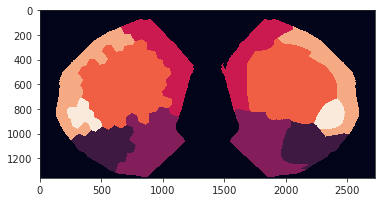

In [260]:
affil_max_flat = np.zeros_like(parcel_flat)
for r, af in affil['regions_affil_max'].items():
    affil_max_flat[parcel_flat == r] = list(affil['affiliation']).index(af) + 1

m = np.isin(parcel_flat, affil['regions_r'])
affil_max_flat[m] = affil['obj_flat'][m]
affil_max_flat[parcel_flat == 0] = 0
plt.imshow(affil_max_flat);

In [281]:
regions_included = [
    mice.parcel.encode(1, int(lbl.split('-')[1]), 0)
    for lbl in gr_ca.l2n
]
regions_included = np.array(regions_included)
regions_included = regions_included[gr_ca.l_ids]

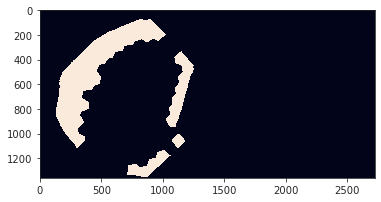

In [282]:
mask = np.zeros(parcel_flat.shape)
mask[np.isin(parcel_flat, affil['regions_l'])] = 1
mask[np.isin(parcel_flat, regions_included)] = 0
plt.imshow(mask);

In [283]:
m_tr, afmf_tr = filter_boundaries([mask, affil_max_flat], mask=affil_max_flat)

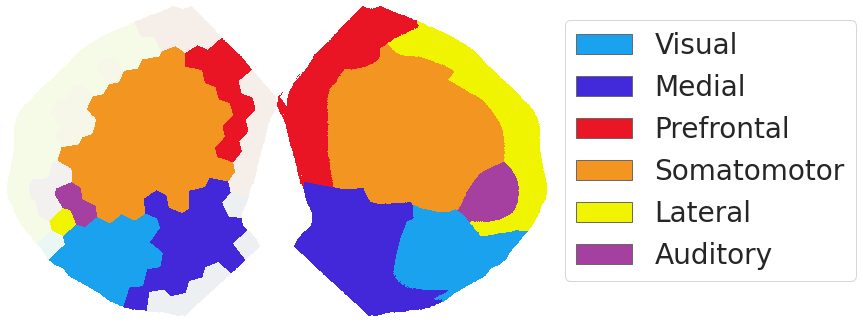

In [291]:
from matplotlib.patches import Patch

fig, ax = create_figure(figsize=(12, 6))

x2plt = np.ma.masked_where(afmf_tr == 0, afmf_tr)
ax.imshow(x2plt, cmap=affil['cmap'])


x2plt = np.ma.masked_where(m_tr == 0, m_tr)
ax.imshow(x2plt, cmap='Greens', interpolation='none', alpha=0.95)

legend_elements = [
    Patch(facecolor=c, edgecolor='dimgrey', label=lbl)
    for lbl, c in affil['colors'].items()
]
leg = ax.legend(handles=legend_elements, fontsize=28)
plt.setp(leg, bbox_to_anchor=(1.6, 1.0))
remove_ticks(ax)

name = f'affil-flat'
figname = f"{name}.pdf"
fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
for dpi in [100, 300, 600]:
    figname = f"{name}_dpi{dpi}.png"
    fig.savefig(pjoin(fig_dir, figname), dpi=dpi, bbox_inches='tight', transparent=True)

plt.show()

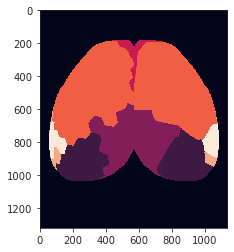

In [267]:
affil_max_top = np.zeros_like(parcel_top)
for r, af in affil['regions_affil_max'].items():
    affil_max_top[parcel_top == r] = list(affil['affiliation']).index(af) + 1

m = np.isin(parcel_top, affil['regions_r'])
affil_max_top[m] = affil['obj_top'][m]
affil_max_top[parcel_top == 0] = 0
plt.imshow(affil_max_top);

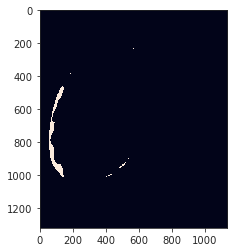

In [268]:
mask = np.zeros(parcel_top.shape)
mask[np.isin(parcel_top, affil['regions_l'])] = 1
mask[np.isin(parcel_top, regions_included)] = 0
plt.imshow(mask);

In [269]:
m_tr, afmf_tr = filter_boundaries([mask, affil_max_top], mask=affil_max_top)

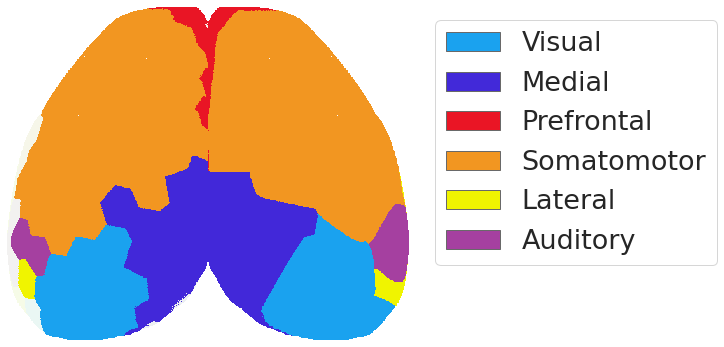

In [280]:
from matplotlib.patches import Patch

fig, ax = create_figure(figsize=(10, 5))

x2plt = np.ma.masked_where(afmf_tr == 0, afmf_tr)
ax.imshow(x2plt, cmap=affil['cmap'])


x2plt = np.ma.masked_where(m_tr == 0, m_tr)
ax.imshow(x2plt, cmap='Greens', interpolation='none', alpha=0.95)

legend_elements = [
    Patch(facecolor=c, edgecolor='dimgrey', label=lbl)
    for lbl, c in affil['colors'].items()
]
leg = ax.legend(handles=legend_elements, fontsize=27)
plt.setp(leg, bbox_to_anchor=(1.8, 1.0))
remove_ticks(ax)

name = f'affil-top'
figname = f"{name}.pdf"
fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
for dpi in [100, 300, 600]:
    figname = f"{name}_dpi{dpi}.png"
    fig.savefig(pjoin(fig_dir, figname), dpi=dpi, bbox_inches='tight', transparent=True)

plt.show()

## Layer plots

In [10]:
template = mice.al.mcc.get_template_volume()[0]
layer_mask_coarse, layer_mask = mice.al.make_layer_mask()

layer_mask_3 = sum(
    e.astype('int32') * i for i, e in
    enumerate(layer_mask_coarse.values(), start=1)
)

<matplotlib.image.AxesImage object at 0x7f3a1f7d8b80>

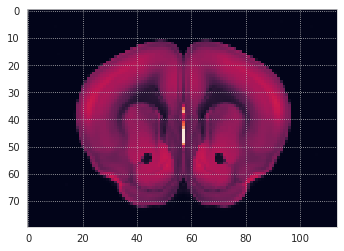

In [16]:
plt.imshow(template[40])

In [33]:
fig_dir

'/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_25th'

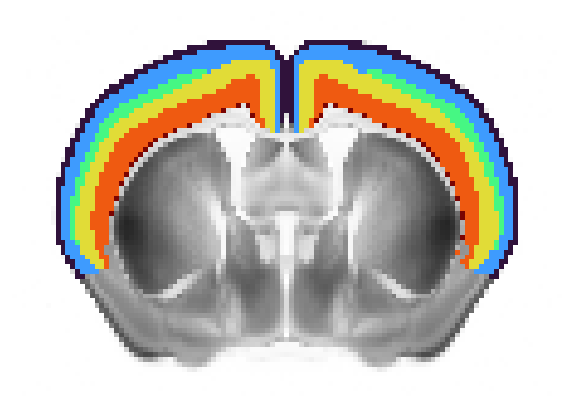

In [42]:
i = 55

fig, ax = create_figure(1, 1, (8, 6))
ax.imshow(template[i], cmap='Greys')

x2p = np.ma.masked_where(layer_mask[i] == 0, layer_mask[i])
ax.imshow(x2p, cmap='turbo')

remove_ticks(ax)

name = f'CCF-layers'
figname = f"{name}.pdf"
fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
for dpi in [100, 300, 600]:
    figname = f"{name}_dpi{dpi}.png"
    fig.savefig(pjoin(fig_dir, figname), dpi=dpi, bbox_inches='tight')

plt.show()

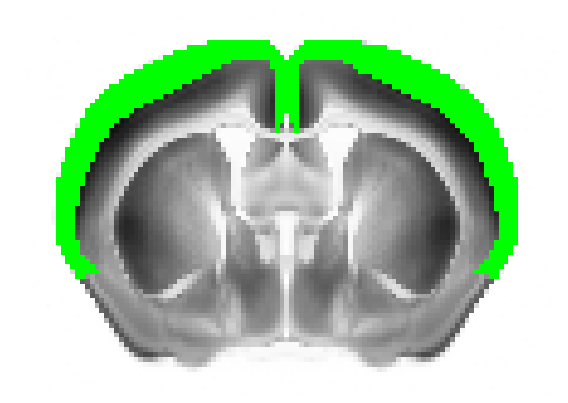

In [52]:
i = 55

fig, ax = create_figure(1, 1, (8, 6))
ax.imshow(template[i], cmap='Greys')

x2p = np.ma.masked_where(layer_mask_coarse['depth-0'][i] == 0, layer_mask_coarse['depth-0'][i])
ax.imshow(x2p, cmap=sns.light_palette('lime', as_cmap=True, reverse=True))

remove_ticks(ax)

name = f'CCF-depth-0'
figname = f"{name}.pdf"
fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
for dpi in [100, 300, 600]:
    figname = f"{name}_dpi{dpi}.png"
    fig.savefig(pjoin(fig_dir, figname), dpi=dpi, bbox_inches='tight', transparent=True)

plt.show()

In [56]:
(gr_bold.grp_pi > 0.15).sum(1)

array([ 69,  73,  67,  95, 110])

In [57]:
(gr_ca.grp_pi > 0.15).sum(1)

array([69, 77, 79, 74, 89])